# Train Networks

- Three-way SoftMax or Multi-BCE classifier of normal, non-vascular MCI, and non-vascular dementia
- `Weights and Biases` sweep is used for hyperparameter search

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import json
from copy import deepcopy

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import wandb

# custom package
from datasets.cau_eeg_dataset import *
from datasets.cau_eeg_script import *
from models import *
from train import *

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0
cuda is available.


-----

## Set the default configuration for building datatset

In [ ]:
cfg_data = {}
cfg_data['device'] = device
cfg_data['dataset'] = 'CAUHS'
cfg_data['data_path'] = r'local/dataset/02_Curated_Data_220322/'
cfg_data['meta_path'] = os.path.join(cfg_data['data_path'], 'metadata_debug.json')
cfg_data['file_format'] = 'feather'  # 'feather', 'memmap'
cfg_data['target_task'] = 'Normal, MCI, Dementia' # 'Norml, MCI, Dementia'
cfg_data['vascular'] = 'X'
cfg_data['segment'] = 'no' # 'train', 'all', 'no'
cfg_data['seed'] = 0
cfg_data['crop_length'] = 200 * 10 # 10 seconds
cfg_data['longer_crop_length'] = 200 * 10 * 10 # 100 seconds
cfg_data['crop_multiple'] = 8
cfg_data['minibatch'] = 1024
cfg_data['input_norm'] = 'dataset' # 'datatset', 'datapoint', 'no'
cfg_data['EKG'] = 'O'
cfg_data['photic'] = 'X'
cfg_data['awgn'] = 5e-2
cfg_data['mgn'] = 1e-4
cfg_data['awgn_age'] = 5e-2

In [ ]:
_ = build_dataset(cfg_data, verbose=True)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
test_loader_longer = _[3]
preprocess_train = _[4]
preprocess_test = _[5]
class_label_to_type = _[6]

-----

## Define Network Models

In [ ]:
if cfg_data.get('crop_multiple', 1) == 1:
    cfg_common_model = {'in_channels': _[0].dataset[0]['signal'].shape[0], 
                        'out_dims': len(_[-1])}
else:
    cfg_common_model = {'in_channels': _[0].dataset[0]['signal'][0].shape[0], 
                        'out_dims': len(_[-1])}

del _
cfg_model_pool = []

#### 1D Tiny CNN

In [ ]:
cfg_model = {}
cfg_model.update(cfg_common_model)
cfg_model['model'] = '1D-Tiny-CNN'
cfg_model['generator'] = TinyCNN1D
cfg_model['fc_stages'] = 3
cfg_model['use_age'] = 'fc'
cfg_model['final_pool'] = 'max'
cfg_model['base_channels'] = 64
cfg_model['LR'] = None
cfg_model['dropout'] = 0.3
cfg_model['activation'] = 'mish'

pprint.pprint('Model config:')
pprint.pprint(cfg_model)
print('\n' + '-' * 100 + '\n')
    
model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
print(model)
print('\n' + '-' * 100 + '\n')

del model
cfg_model_pool.append(cfg_model)

#### M7 model (fc-age)

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-Mx'
# cfg_model['generator'] = M7
# cfg_model['fc_stages'] = 1
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 256
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 1D ResNet model (fc-age)

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-ResNet-2x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = BottleneckBlock1D
# cfg_model['conv_layers'] = [2, 2, 2, 2]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### Deeper 1D ResNet model (fc-age)

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-ResNet-5x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = BottleneckBlock1D
# cfg_model['conv_layers'] = [3, 4, 6, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### Shallower 1D ResNet

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-ResNet-2x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = BasicBlock1D
# cfg_model['conv_layers'] = [2, 2, 2, 2]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### Tiny 1D ResNet model

In [ ]:
cfg_model = {}
cfg_model.update(cfg_common_model)
cfg_model['model'] = '1D-ResNet-1x'
cfg_model['generator'] = ResNet1D
cfg_model['block'] = BasicBlock1D
cfg_model['conv_layers'] = [1, 1, 1, 1]
cfg_model['fc_stages'] = 3
cfg_model['use_age'] = 'fc'
cfg_model['final_pool'] = 'max'
cfg_model['base_channels'] = 64
cfg_model['LR'] = None
cfg_model['activation'] = 'mish'

pprint.pprint('Model config:')
pprint.pprint(cfg_model)
print('\n' + '-' * 100 + '\n')
    
model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
print(model)
print('\n' + '-' * 100 + '\n')

del model
cfg_model_pool.append(cfg_model)

#### Multi-Dilated 1D ResNet model

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-Multi-Dilated-ResNet-5x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = MultiBottleneckBlock1D
# cfg_model['conv_layers'] = [3, 4, 6, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 32
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 1D ResNeXt-53

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-ResNeXt-5x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = BottleneckBlock1D
# cfg_model['conv_layers'] = [3, 4, 6, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['groups'] = 32
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 1D ResNeXt-103

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-ResNeXt-10x'
# cfg_model['generator'] = ResNet1D
# cfg_model['block'] = BottleneckBlock1D
# cfg_model['conv_layers'] = [3, 4, 23, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['groups'] = 32
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')
    
# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 2D ResNet-20 model

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '2D-ResNet-2x' # resnet-18 + three more fc layer
# cfg_model['generator'] = ResNet2D
# cfg_model['block'] = BasicBlock2D
# cfg_model['conv_layers'] = [2, 2, 2, 2]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['n_fft'] = 100
# cfg_model['complex_mode'] = 'as_real' # 'power', 'remove'
# cfg_model['hop_length'] = cfg_model['n_fft'] // 2
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')

# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 2D ResNet-52 model

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '2D-ResNet-5x' # resnet-50 + three more fc layer
# cfg_model['generator'] = ResNet2D
# cfg_model['block'] = Bottleneck2D
# cfg_model['conv_layers'] = [3, 4, 6, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['n_fft'] = 100
# cfg_model['complex_mode'] = 'as_real' # 'power', 'remove'
# cfg_model['hop_length'] = cfg_model['n_fft'] // 2
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')

# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### 2D ResNeXt-104 model

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '2D-ResNeXt-10x' # resnet-101 + three more fc layer
# cfg_model['generator'] = ResNet2D
# cfg_model['block'] = Bottleneck2D
# cfg_model['conv_layers'] = [3, 4, 23, 3]
# cfg_model['fc_stages'] = 3
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 64
# cfg_model['n_fft'] = 100
# cfg_model['complex_mode'] = 'as_real' # 'power', 'remove'
# cfg_model['hop_length'] = cfg_model['n_fft'] // 2
# cfg_model['groups'] = 32
# cfg_model['width_per_group'] = 8
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')

# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### CNN-Transformer

In [ ]:
# cfg_model = {}
# cfg_model.update(cfg_common_model)
# cfg_model['model'] = '1D-CNN-Transformer'
# cfg_model['generator'] = CNNTransformer
# cfg_model['fc_stages'] = 2
# cfg_model['use_age'] = 'fc'
# cfg_model['final_pool'] = 'max'
# cfg_model['base_channels'] = 256
# cfg_model['n_encoders'] = 4
# cfg_model['n_heads'] = 4
# cfg_model['dropout'] = 0.2
# cfg_model['LR'] = None
# cfg_model['activation'] = 'relu'

# pprint.pprint('Model config:')
# pprint.pprint(cfg_model)
# print('\n' + '-' * 100 + '\n')

# model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)
# print(model)
# print('\n' + '-' * 100 + '\n')

# del model
# cfg_model_pool.append(cfg_model)

#### Summarize the model pool

In [ ]:
for cfg_model in cfg_model_pool:
    pprint.pp(cfg_model, width=150)
    print('\n' + '-' * 100 + '\n')

#### Selected model

In [ ]:
model_index = 0
cfg_model = cfg_model_pool[model_index]

pprint.pp(cfg_model, width=150)

-----

## Default Configurations for Training

In [ ]:
# training configurations
cfg_train = {}
cfg_train['iterations'] = (150000 * 32) // cfg_data['minibatch']
cfg_train['num_history'] = 500
cfg_train['lr_decay_timing'] = 0.8
cfg_train['lr_decay_gamma'] = 0.1
cfg_train['weight_decay'] = 1e-2
cfg_train['mixup'] = 0.0 # 0 for no usage
cfg_train['criterion'] = 'cross-entropy' # 'cross-entropy', 'multi-bce'

cfg_train['device'] = device
cfg_train['save_model'] = True
cfg_train['save_temporary'] = False
cfg_train['draw_result'] = True
cfg_train['watch_model'] = False

-----

## Train

In [30]:
wandb_run = wandb.init(project="eeg-analysis")
wandb.run.name = wandb.run.id

with wandb_run:
    # wandb config update
    config = {}
    for k, v in {**cfg_data, **cfg_train, **cfg_model}.items():
        if k not in wandb.config:
            config[k] = v

    # to prevent callables from type-conversion to str
    config['history_interval'] = config['iterations'] // config['num_history']
    wandb.config.update(config)
    for k, v in wandb.config.items():
        if k not in config:
            config[k] = v

    if cfg_data.get('crop_multiple', 1) == 1:
        config['in_channels'] = train_loader.dataset[0]['signal'].shape[0]
    else:
        config['in_channels'] = train_loader.dataset[0]['signal'][0].shape[0]
    config['out_dims'] = len(class_label_to_type)

    # train the model
    train_with_wandb(config, train_loader, val_loader, test_loader, test_loader_longer, 
                     preprocess_train, preprocess_test, class_label_to_type)

Problem at: C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20768\3387908297.py 1 <cell line: 1>


KeyboardInterrupt: 

In [56]:
a = np.random.randn(50, 3)
a[:, 0] = np.arange(50)
a = a.tolist()

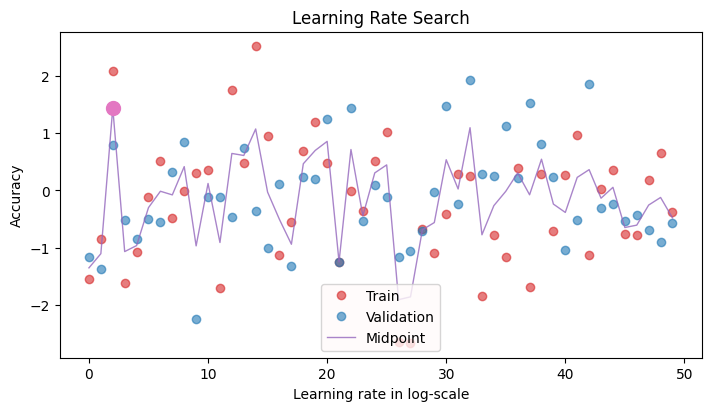

In [60]:
draw_learning_rate_record(a, use_wandb=False)

In [61]:
wandb_run = wandb.init(project="eeg-analysis")
wandb.run.name = wandb.run.id
with wandb_run:
    draw_learning_rate_record(a, use_wandb=True)